In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import tensorflow as tf

# MediaPipe

In [2]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [3]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    visibility_scores = []
    landmark_color=(0,0, 225)
    line_color=(0, 0, 0)

    # Check if any landmarks are detected.
    if results.pose_landmarks:
        for i in range(33):
            # Display the found landmarks after converting them into their original scale.
            print(f'{mp_pose.PoseLandmark(i).name}:') 
            print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x }')
            print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y }')
            print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z }')
            
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=landmark_color, thickness=5, circle_radius=5),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=line_color, thickness=5))
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
            visibility_scores.append(landmark.visibility)
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
        
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        return results.pose_landmarks,visibility_scores
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks,visiblity_scores

NOSE:
x: 0.4401371479034424
y: 0.27770549058914185
z: 0.03677436709403992
LEFT_EYE_INNER:
x: 0.4384945034980774
y: 0.2538760006427765
z: 0.020844576880335808
LEFT_EYE:
x: 0.4413266181945801
y: 0.25034230947494507
z: 0.020613782107830048
LEFT_EYE_OUTER:
x: 0.4441610872745514
y: 0.24762825667858124
z: 0.020685458555817604
RIGHT_EYE_INNER:
x: 0.43310171365737915
y: 0.26119688153266907
z: 0.056595467031002045
RIGHT_EYE:
x: 0.43204712867736816
y: 0.2624240219593048
z: 0.0562853068113327
RIGHT_EYE_OUTER:
x: 0.4307171106338501
y: 0.2638965845108032
z: 0.056115150451660156
LEFT_EAR:
x: 0.4605383276939392
y: 0.2424243837594986
z: -0.00770006375387311
RIGHT_EAR:
x: 0.4410804212093353
y: 0.2601549029350281
z: 0.15351726114749908
MOUTH_LEFT:
x: 0.4508903920650482
y: 0.28430646657943726
z: 0.03198777511715889
MOUTH_RIGHT:
x: 0.44574111700057983
y: 0.29290908575057983
z: 0.0767609179019928
LEFT_SHOULDER:
x: 0.504777729511261
y: 0.27292317152023315
z: -0.13937731087207794
RIGHT_SHOULDER:
x: 0.4683534

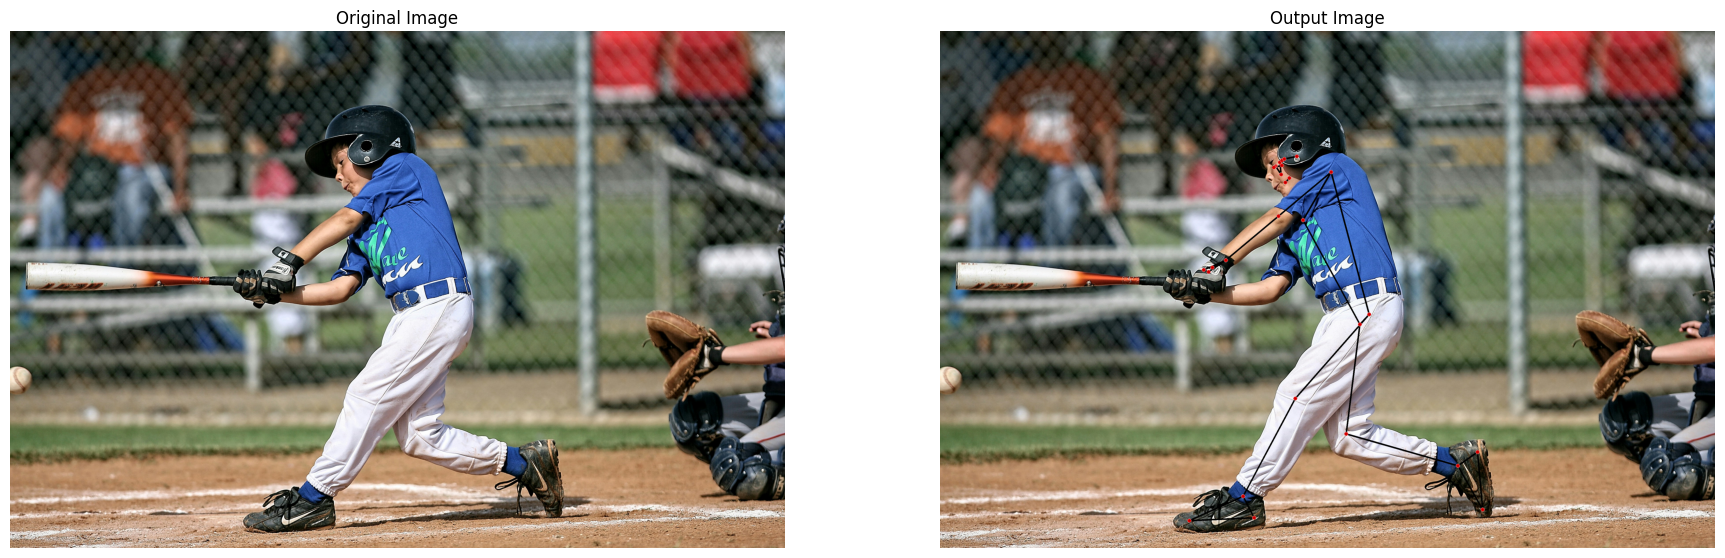

In [4]:
# Read another sample image and perform pose detection on it.
image = cv2.imread('media/pose3.jpg')
pred,v_mediapipe=detectPose(image, pose, display=True)


In [5]:
v_mediapipe

[0.9994638562202454,
 0.9996347427368164,
 0.9996035695075989,
 0.9996659755706787,
 0.999815046787262,
 0.9998284578323364,
 0.9998679161071777,
 0.999681830406189,
 0.9996947050094604,
 0.9991983771324158,
 0.9989099502563477,
 0.999828577041626,
 0.9997192025184631,
 0.954623818397522,
 0.07993172854185104,
 0.7427544593811035,
 0.3902813792228699,
 0.7341091632843018,
 0.43984583020210266,
 0.7329502105712891,
 0.4511655569076538,
 0.6640214323997498,
 0.4313589334487915,
 0.9999914169311523,
 0.999995231628418,
 0.8730361461639404,
 0.930759608745575,
 0.9644490480422974,
 0.9521108865737915,
 0.960197925567627,
 0.9638484120368958,
 0.948203444480896,
 0.912021815776825]

# OpenPose

In [6]:
net = cv2.dnn.readNetFromTensorflow("graph_opt.pb") ## weights
inWidth = 368
inHeight = 368
thr = 0.2
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["RHip", "RKnee"], ["RKnee", "RAnkle"],["RShoulder", "RHip"],["RShoulder", "LShoulder"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Nose", "REye"],["LShoulder", "LHip"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [7]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv2.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]
    
    assert(len(BODY_PARTS) == out.shape[1])
    
    points = {}
    visibility_scores = {}
    p={}
    for part, part_id in BODY_PARTS.items():
        heatMap = out[0, part_id, :, :]
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        p[part] = (point[0]/45, point[1]/45) if conf > thr else None
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        visibility_scores[part]=(conf)
        points[part] = (int(x), int(y)) if conf > thr else None
        
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[partFrom] and points[partTo]:
            cv2.line(frame, points[partFrom], points[partTo], (0, 255, 0), 3)
            cv2.ellipse(frame, points[partFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[partTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
        
    t, _ = net.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000
    cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return frame,p,visibility_scores


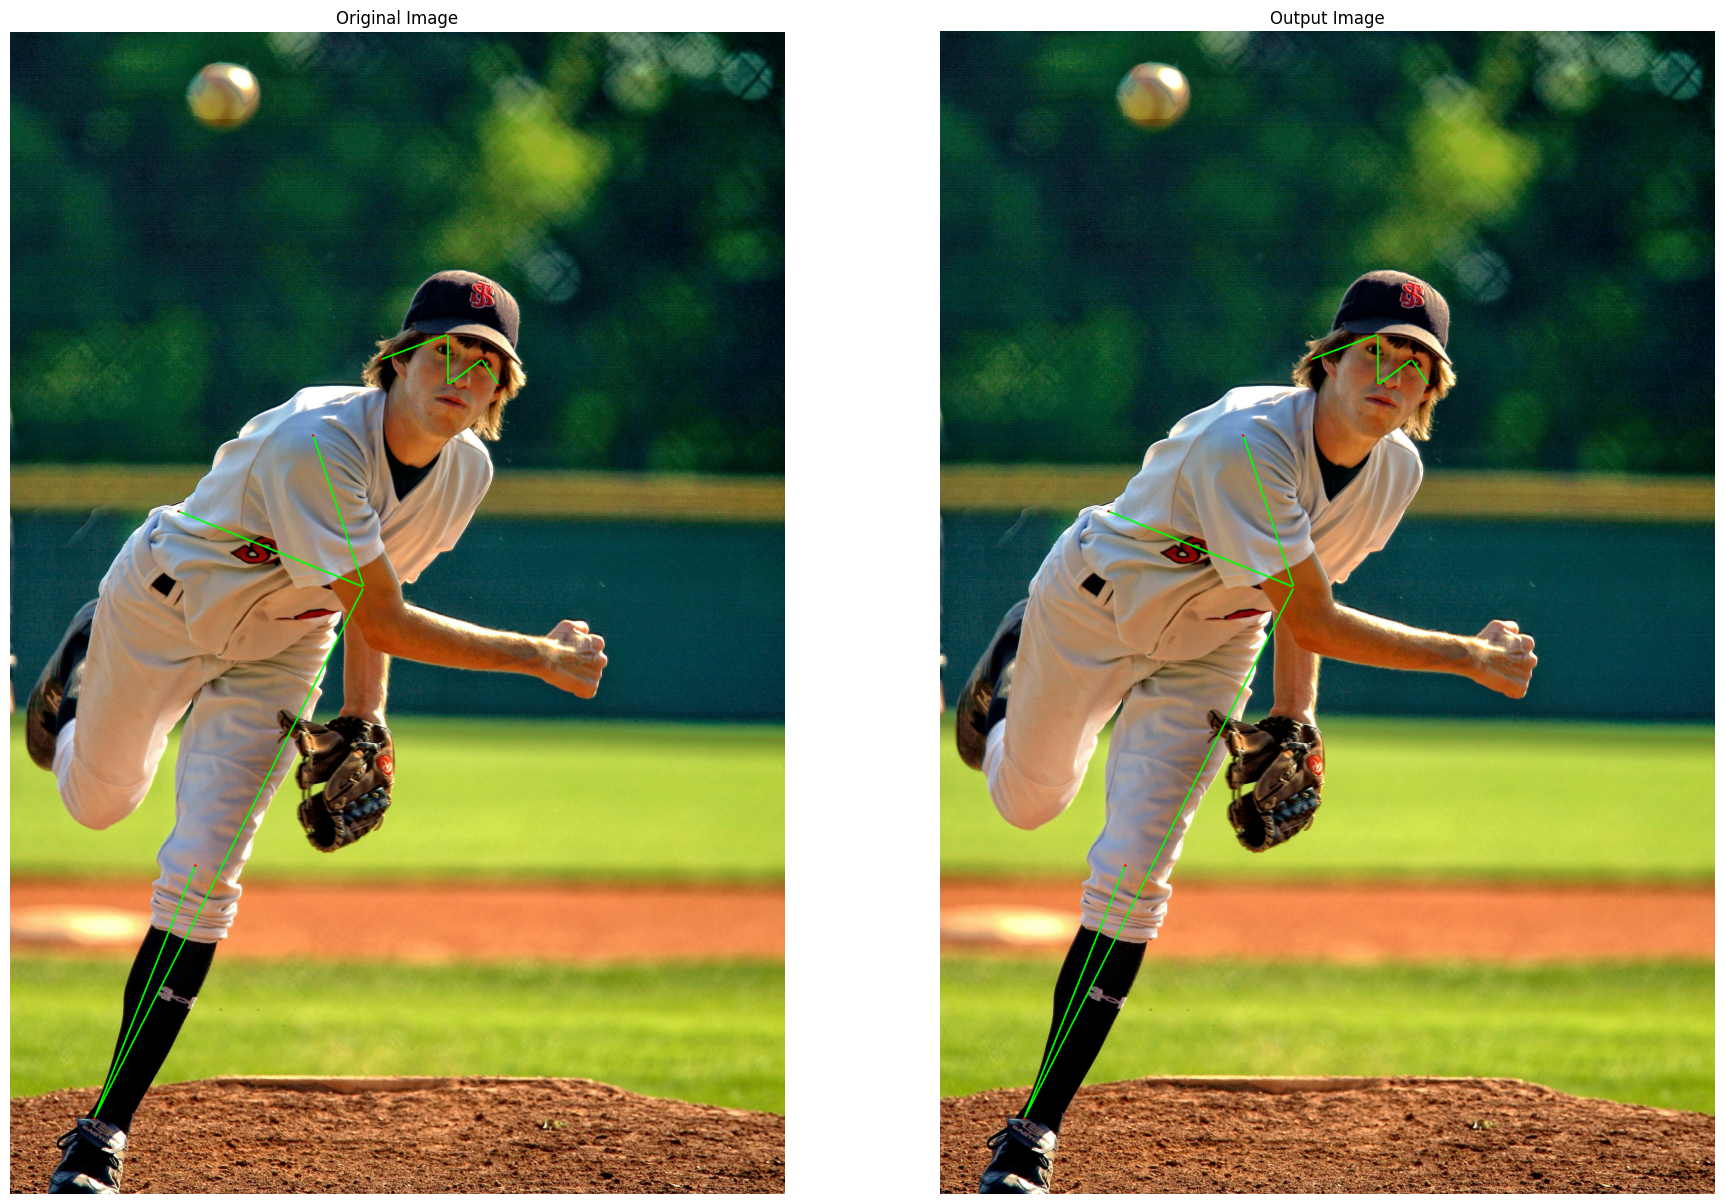

In [8]:
img = cv2.imread("media/pose4.jpg")
estimated_image,pointsop,v_openpose = pose_estimation(img)
plt.figure(figsize=[22,22])
plt.subplot(121);plt.imshow(img[:,:,::-1]);plt.title("Original Image");plt.axis('off');
plt.subplot(122);plt.imshow(estimated_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

In [9]:
v_openpose

{'Nose': 0.6501483917236328,
 'Neck': 0.3453807830810547,
 'RShoulder': 0.4329526424407959,
 'RElbow': 0.33287113904953003,
 'RWrist': 0.2019161581993103,
 'LShoulder': 0.15065284073352814,
 'LElbow': 0.1223611980676651,
 'LWrist': 0.027445955201983452,
 'RHip': 0.18746186792850494,
 'RKnee': 0.21607473492622375,
 'RAnkle': 0.28901100158691406,
 'LHip': 0.1974988430738449,
 'LKnee': 0.2715175747871399,
 'LAnkle': 0.34144553542137146,
 'REye': 0.6190064549446106,
 'LEye': 0.6637949347496033,
 'REar': 0.5820657014846802,
 'LEar': 0.3206828236579895,
 'Background': 1.0025930404663086}

In [10]:
pointsop

{'Nose': (0.5777777777777777, 0.3111111111111111),
 'Neck': (0.4666666666666667, 0.37777777777777777),
 'RShoulder': (0.4, 0.35555555555555557),
 'RElbow': (0.4666666666666667, 0.4888888888888889),
 'RWrist': (0.2222222222222222, 0.4222222222222222),
 'LShoulder': None,
 'LElbow': None,
 'LWrist': None,
 'RHip': None,
 'RKnee': (0.4666666666666667, 0.4888888888888889),
 'RAnkle': (0.1111111111111111, 0.9555555555555556),
 'LHip': None,
 'LKnee': (0.24444444444444444, 0.7333333333333333),
 'LAnkle': (0.1111111111111111, 0.9555555555555556),
 'REye': (0.5777777777777777, 0.26666666666666666),
 'LEye': (0.6222222222222222, 0.28888888888888886),
 'REar': (0.4888888888888889, 0.28888888888888886),
 'LEar': (0.6444444444444445, 0.3111111111111111),
 'Background': (1.0, 0.28888888888888886)}

# Movenet

In [11]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()
input_size = 192

In [12]:
def movenet(input_image):
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

In [13]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}
# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [14]:
def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.15):
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
    # Geting keypoints above threshload valye
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)
    # printing Edges
    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors



In [15]:
def drbaw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

In [16]:
def draw_prediction_on_image(image, keypoints_with_scores):
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle='solid')
    ax.add_collection(line_segments)
    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    (keypoint_locs, keypoint_edges, edge_colors) = _keypoints_and_edges_for_display(
        keypoints_with_scores, height, width)

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    fig.canvas.draw()
    output_overlay = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    output_overlay = output_overlay.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return output_overlay

In [17]:
def process_image(image_path):
    # Load the input image
    image = cv2.imread(image_path)

    # Get the original image size
    original_height, original_width, _ = image.shape

    # Resize and pad the image to the model's input size
    input_image = cv2.resize(image, (input_size, input_size))
    input_image = np.expand_dims(input_image, axis=0)

    # Run model inference
    keypoints_with_scores = movenet(input_image)
    
    # Visualize the predictions with the original image
    output_overlay = draw_prediction_on_image(image, keypoints_with_scores)

    # Save the result with modified image name and format
    result_image_name = image_path.split('.')[0] + '_result.' + image_path.split('.')[1]
    cv2.imwrite(result_image_name, output_overlay)
    output_image=cv2.imread(result_image_name)
    plt.figure(figsize=[22,22])
    plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
    plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    return result_image_name,keypoints_with_scores

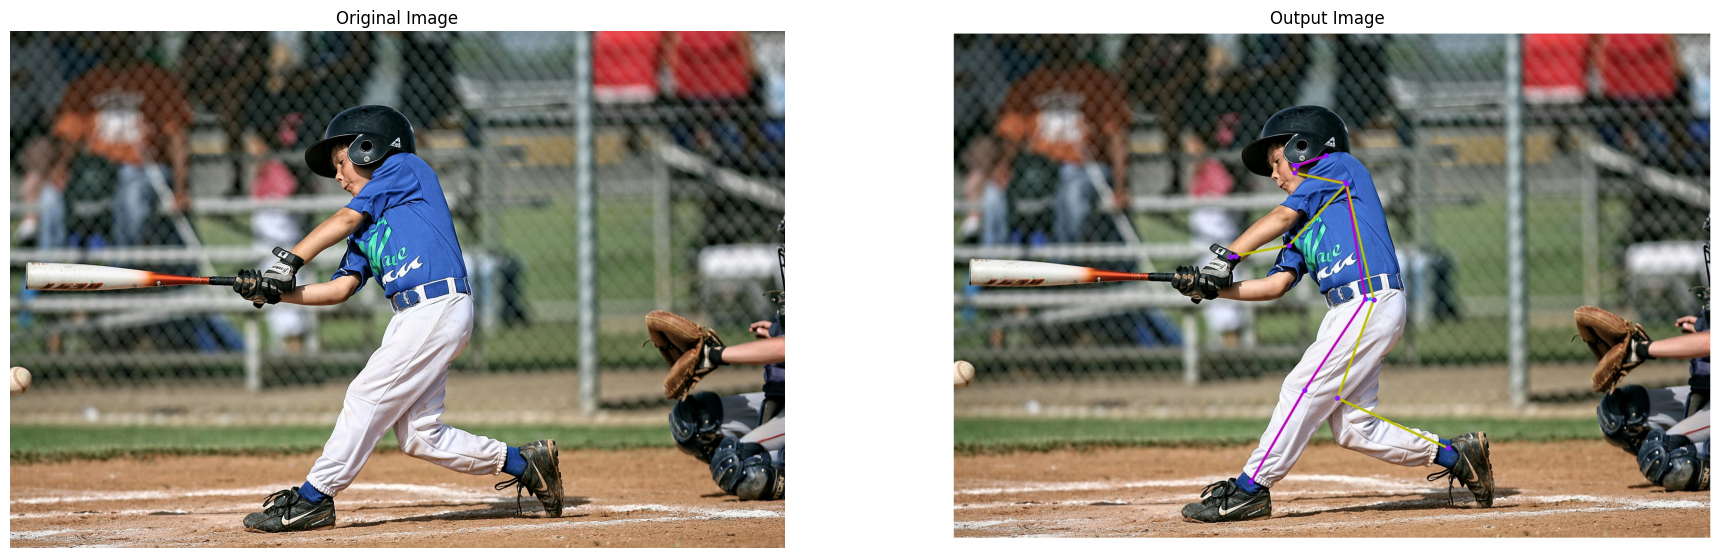

In [18]:
result_image,keypoints_with_scores=process_image('media/pose3.jpg')

# PreProcess

In [19]:
# 'nose', 'left_eye','right_eye','left_ear','right_ear','left_shoulder','right_shoulder','left_elbow','right_elbow',
# left_wrist','right_wrist','left_hip','right_hip','left_knee','right_knee','left_ankle','right_ankle'
keypoints_with_scores

array([[[[0.27652088, 0.45072302, 0.44576284],
         [0.26281288, 0.45324653, 0.3084006 ],
         [0.26111332, 0.44936392, 0.23508905],
         [0.24223447, 0.4921324 , 0.41368297],
         [0.24747758, 0.47537082, 0.13626927],
         [0.29606196, 0.5180251 , 0.37765828],
         [0.29794383, 0.5191887 , 0.39960515],
         [0.41947615, 0.48973832, 0.14104106],
         [0.4202635 , 0.44295663, 0.2687221 ],
         [0.4414621 , 0.3726141 , 0.28855577],
         [0.4422967 , 0.3660751 , 0.37650016],
         [0.526677  , 0.5442213 , 0.5507786 ],
         [0.52783984, 0.5552926 , 0.57319987],
         [0.7073397 , 0.4635436 , 0.40768185],
         [0.72297204, 0.50689924, 0.315861  ],
         [0.8888158 , 0.39280435, 0.5682619 ],
         [0.82190675, 0.65335375, 0.54770863]]]], dtype=float32)

NOSE:
x: 0.5955324172973633
y: 0.3036368489265442
z: -0.3084799647331238
LEFT_EYE_INNER:
x: 0.5985840559005737
y: 0.2914823889732361
z: -0.2798919081687927
LEFT_EYE:
x: 0.5999265909194946
y: 0.29094618558883667
z: -0.28034698963165283
LEFT_EYE_OUTER:
x: 0.6016631722450256
y: 0.29061806201934814
z: -0.2803853154182434
RIGHT_EYE_INNER:
x: 0.5913475155830383
y: 0.290067195892334
z: -0.30575448274612427
RIGHT_EYE:
x: 0.5852596759796143
y: 0.2880244851112366
z: -0.3062048852443695
RIGHT_EYE_OUTER:
x: 0.578403651714325
y: 0.28568774461746216
z: -0.3063889145851135
LEFT_EAR:
x: 0.5773504376411438
y: 0.2865886092185974
z: -0.09020876884460449
RIGHT_EAR:
x: 0.5485894680023193
y: 0.2773147225379944
z: -0.20901770889759064
MOUTH_LEFT:
x: 0.5853860378265381
y: 0.3128538131713867
z: -0.22820496559143066
MOUTH_RIGHT:
x: 0.5771085023880005
y: 0.3104706108570099
z: -0.26626327633857727
LEFT_SHOULDER:
x: 0.6040295958518982
y: 0.34465813636779785
z: -0.00270502595230937
RIGHT_SHOULDER:
x: 0.423412740230

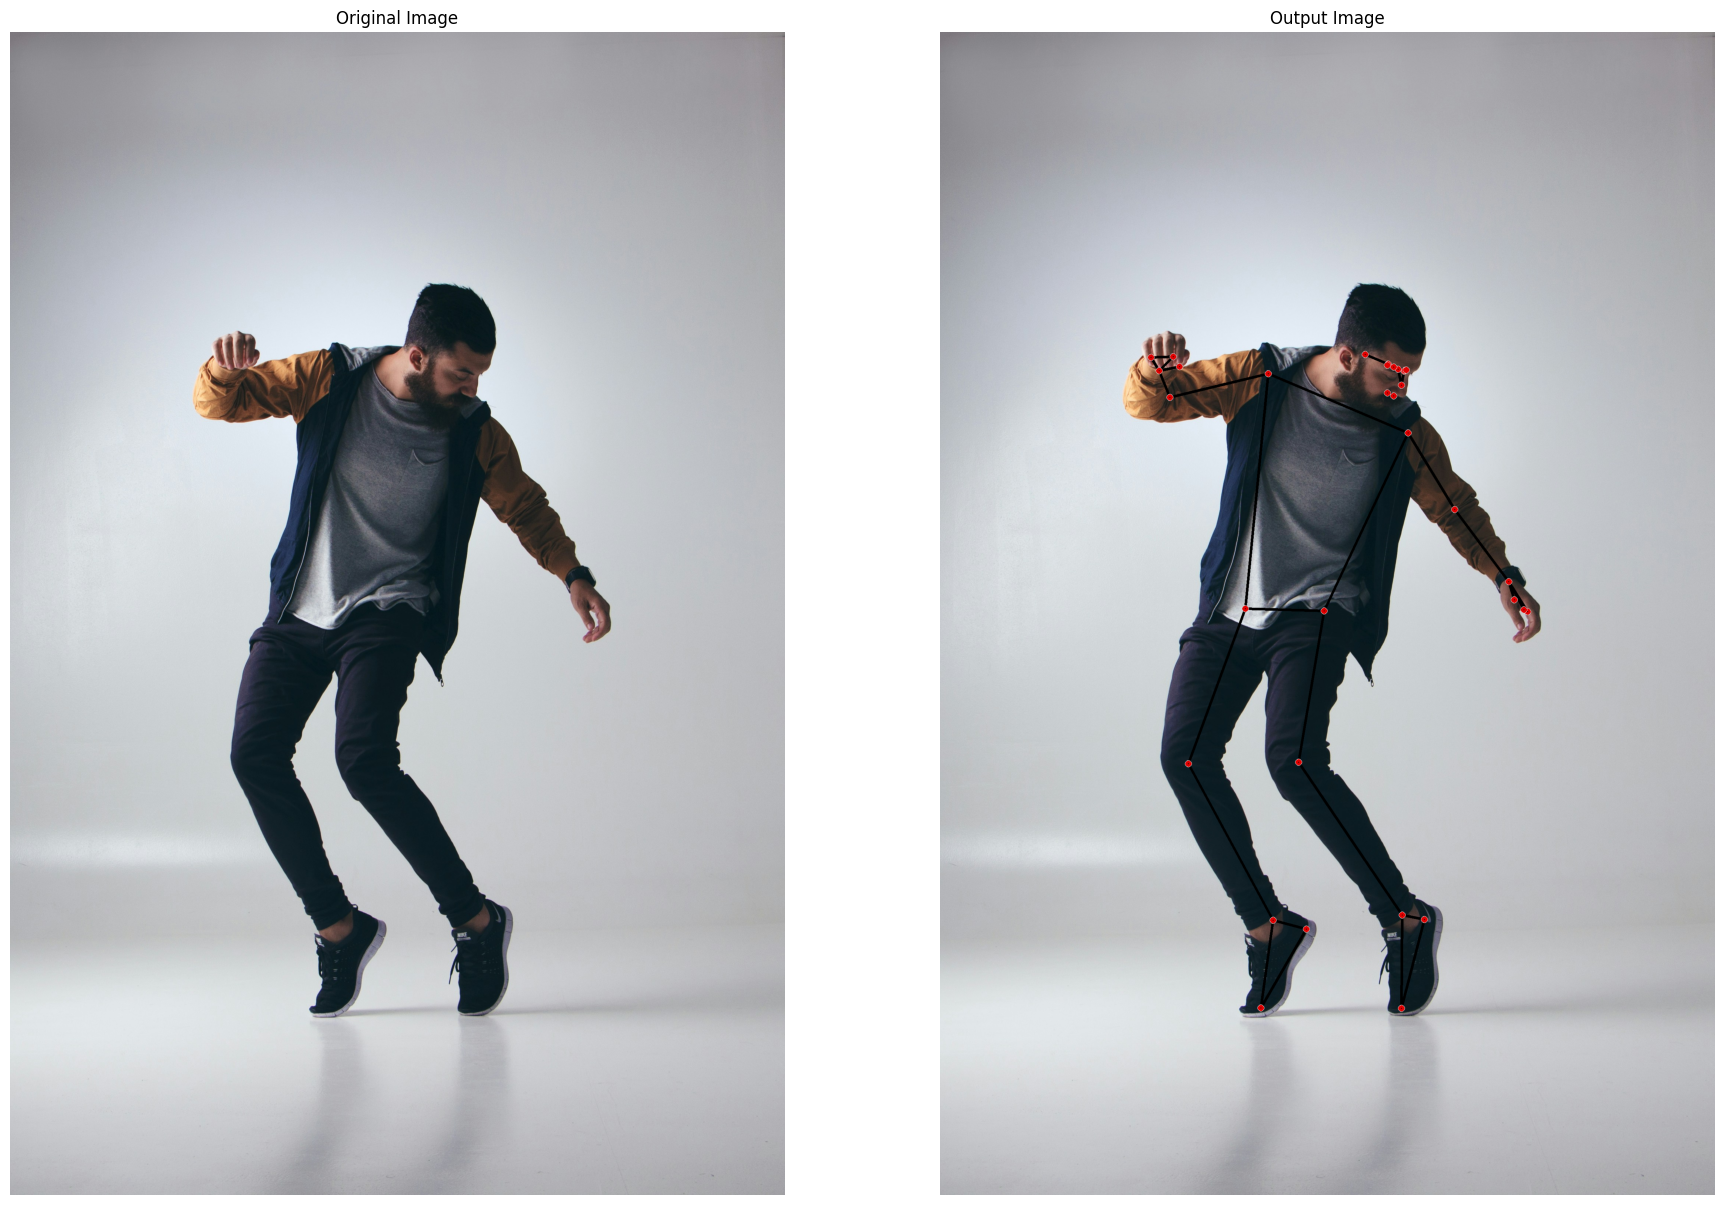

In [20]:
# Read another sample image and perform pose detection on it.
image = cv2.imread('media/pose7.jpg')
pred,v_mediapipe=detectPose(image, pose, display=True)

In [21]:
pred

landmark {
  x: 0.5955324172973633
  y: 0.3036368489265442
  z: -0.3084799647331238
  visibility: 0.9999711513519287
}
landmark {
  x: 0.5985840559005737
  y: 0.2914823889732361
  z: -0.2798919081687927
  visibility: 0.9998924732208252
}
landmark {
  x: 0.5999265909194946
  y: 0.29094618558883667
  z: -0.28034698963165283
  visibility: 0.9999092817306519
}
landmark {
  x: 0.6016631722450256
  y: 0.29061806201934814
  z: -0.2803853154182434
  visibility: 0.9999079704284668
}
landmark {
  x: 0.5913475155830383
  y: 0.290067195892334
  z: -0.30575448274612427
  visibility: 0.9999234676361084
}
landmark {
  x: 0.5852596759796143
  y: 0.2880244851112366
  z: -0.3062048852443695
  visibility: 0.9999493360519409
}
landmark {
  x: 0.578403651714325
  y: 0.28568774461746216
  z: -0.3063889145851135
  visibility: 0.9999371767044067
}
landmark {
  x: 0.5773504376411438
  y: 0.2865886092185974
  z: -0.09020876884460449
  visibility: 0.9999641180038452
}
landmark {
  x: 0.5485894680023193
  y: 0.27

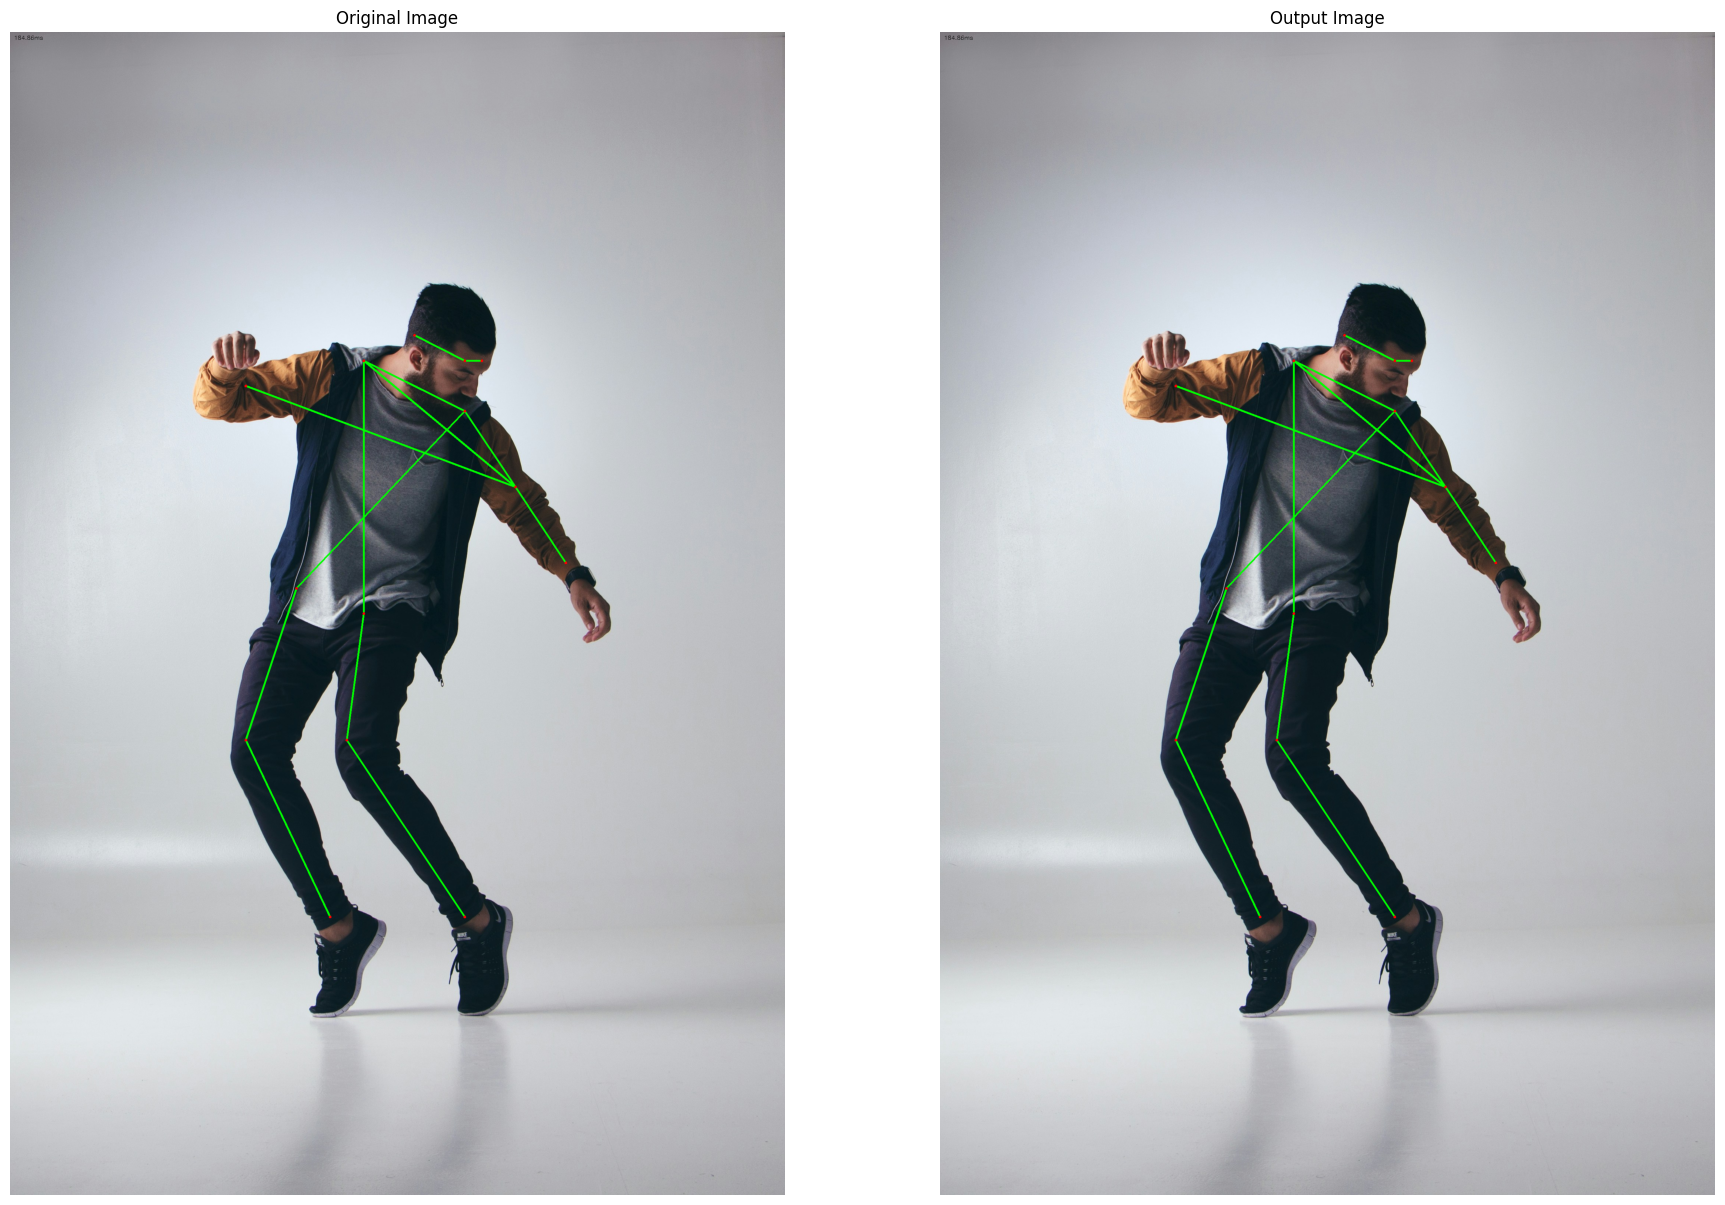

In [22]:
img = cv2.imread("media/pose7.jpg")
estimated_image,points_op,v_openpose = pose_estimation(img)
plt.figure(figsize=[22,22])
plt.subplot(121);plt.imshow(img[:,:,::-1]);plt.title("Original Image");plt.axis('off');
plt.subplot(122);plt.imshow(estimated_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

In [23]:
points_op

{'Nose': (0.6222222222222222, 0.28888888888888886),
 'Neck': (0.5333333333333333, 0.3111111111111111),
 'RShoulder': (0.6, 0.3333333333333333),
 'RElbow': (0.6666666666666666, 0.4),
 'RWrist': (0.3111111111111111, 0.3111111111111111),
 'LShoulder': (0.4666666666666667, 0.28888888888888886),
 'LElbow': (0.6666666666666666, 0.4),
 'LWrist': (0.7333333333333333, 0.4666666666666667),
 'RHip': (0.37777777777777777, 0.4888888888888889),
 'RKnee': (0.3111111111111111, 0.6222222222222222),
 'RAnkle': (0.4222222222222222, 0.7777777777777778),
 'LHip': (0.4666666666666667, 0.5111111111111111),
 'LKnee': (0.4444444444444444, 0.6222222222222222),
 'LAnkle': (0.6, 0.7777777777777778),
 'REye': (0.6, 0.28888888888888886),
 'LEye': None,
 'REar': (0.5333333333333333, 0.26666666666666666),
 'LEar': None,
 'Background': (0.022222222222222223, 0.9777777777777777)}

In [24]:
v_openpose

{'Nose': 0.43094611167907715,
 'Neck': 0.6603462100028992,
 'RShoulder': 0.42242881655693054,
 'RElbow': 0.32370540499687195,
 'RWrist': 0.23007236421108246,
 'LShoulder': 0.44124138355255127,
 'LElbow': 0.4409143030643463,
 'LWrist': 0.6119085550308228,
 'RHip': 0.4824739992618561,
 'RKnee': 0.7755089402198792,
 'RAnkle': 0.6431072950363159,
 'LHip': 0.40845686197280884,
 'LKnee': 0.7187665700912476,
 'LAnkle': 0.695666491985321,
 'REye': 0.5300140976905823,
 'LEye': 0.08306976407766342,
 'REar': 0.5303542017936707,
 'LEar': 0.02755875326693058,
 'Background': 1.0118781328201294}

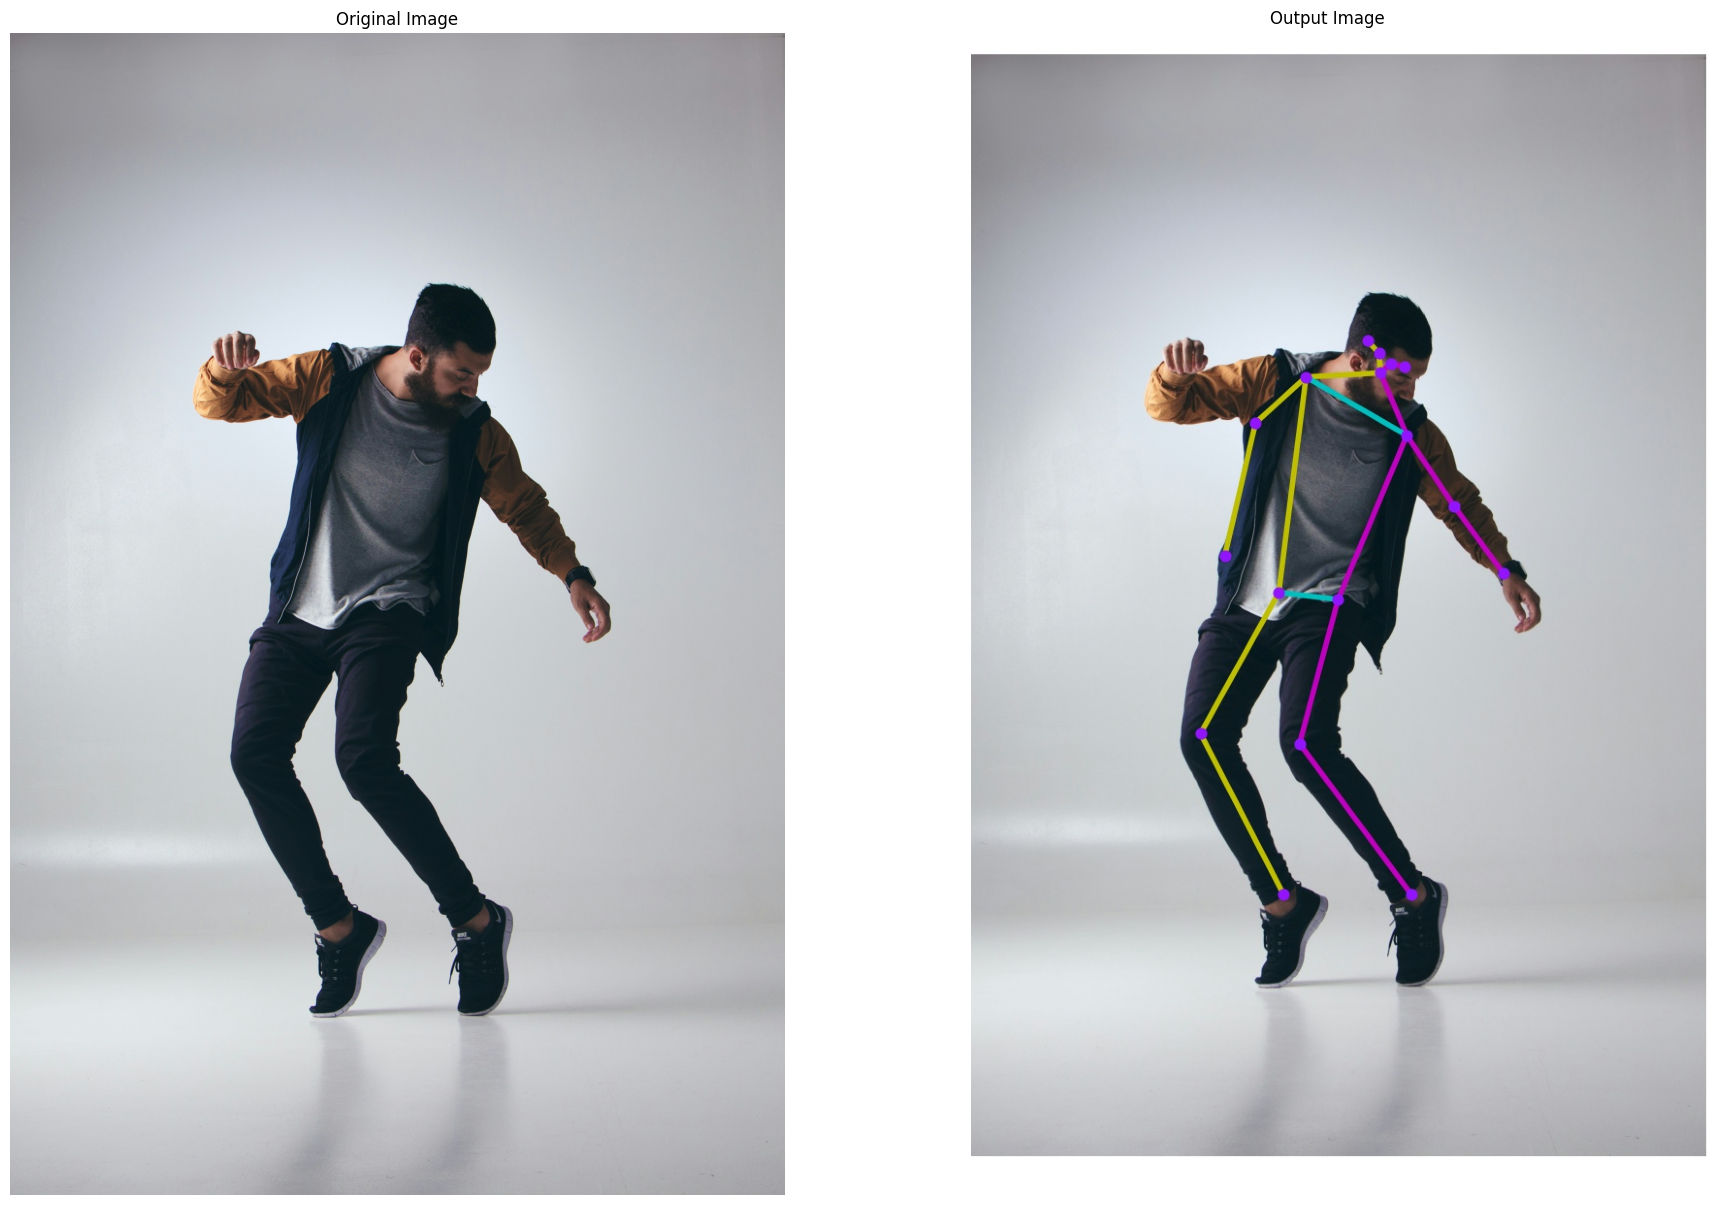

In [25]:
result_image,keypoints_with_scores=process_image('media/pose7.jpg')

In [26]:
keypoints_with_scores

array([[[[0.2889854 , 0.5576687 , 0.3491345 ],
         [0.28047648, 0.57167256, 0.47374335],
         [0.2711584 , 0.5555211 , 0.34426475],
         [0.28348488, 0.5899642 , 0.3355529 ],
         [0.25968242, 0.5397667 , 0.4609002 ],
         [0.34576267, 0.593511  , 0.42884335],
         [0.29276368, 0.45622104, 0.38796884],
         [0.41008943, 0.65804565, 0.61723745],
         [0.3343684 , 0.38762116, 0.40245026],
         [0.47065926, 0.72467417, 0.5836887 ],
         [0.45474964, 0.34573406, 0.5498986 ],
         [0.49472636, 0.49987662, 0.47726527],
         [0.48826954, 0.41919538, 0.49719396],
         [0.62541157, 0.44744617, 0.5696094 ],
         [0.6163159 , 0.3125509 , 0.5065886 ],
         [0.7622623 , 0.59946525, 0.6899282 ],
         [0.7621758 , 0.42550406, 0.4390979 ]]]], dtype=float32)

In [27]:
array = np.array(keypoints_with_scores)
# Convert NumPy array to list
array_list = array.tolist()


# Example keypoints from MoveNet (replace this with your actual keypoints)
movenet_keypoints = array_list[0][0]
movenet_visibility = []
for i in movenet_keypoints:
    movenet_visibility.append(i[2])
# print(movenet_keypoints)
def landmark_list_to_list(normalized_landmark_list):
    landmarks = []
    for landmark in normalized_landmark_list.landmark:
        landmark_dict = {
            'x': landmark.x,
            'y': landmark.y,
            'z': landmark.z,
            'visibility': landmark.visibility,
        }
        landmarks.append(landmark_dict)
    return landmarks


# OpenPose
def convert_coordinates(body_parts):
    # Define the order of body parts
    order = ['Nose', 'LEye', 'REye', 'LEar', 'REar', 
             'LShoulder', 'RShoulder', 'LElbow', 'RElbow', 
             'LWrist', 'RWrist', 'LHip', 'RHip', 
             'LKnee', 'RKnee', 'LAnkle', 'RAnkle']
    
    # Initialize an empty list to store the converted coordinates
    converted_coords = []
    
    # Loop through the order of body parts and add their coordinates if present
    for part in order:
        if part in body_parts:
            x, y = body_parts[part] if body_parts[part] is not None else (0, 0)
            converted_coords.append([(y),(x)])
    
    return converted_coords
openpose_keypoints=convert_coordinates(points_op)

def extract_visibility_scores(visibility_scores, parts_of_interest):
    """
    Extract visibility scores of specified body parts from the visibility_scores dictionary.
    Args:
        visibility_scores: Dictionary containing visibility scores of all body parts.
        parts_of_interest: List of body parts for which visibility scores need to be extracted.
    Returns:
        openpose_visibility: List containing visibility scores of specified body parts.
    """
    openpose_visibility = []
    for part in parts_of_interest:
        if part in visibility_scores:
            openpose_visibility.append(visibility_scores[part])
        else:
            openpose_visibility.append(0)  # If visibility score is not available, append 0
    return openpose_visibility

parts_of_interest = ['Nose', 'LEye', 'REye', 'LEar', 'REar', 
                     'LShoulder', 'RShoulder', 'LElbow', 'RElbow', 
                     'LWrist', 'RWrist', 'LHip', 'RHip', 
                     'LKnee', 'RKnee', 'LAnkle', 'RAnkle']

openpose_visibility = extract_visibility_scores(v_openpose, parts_of_interest)

# Example usage:
# Assuming normalized_landmark_list is your NormalizedLandmarkList object
# Replace this with your actual NormalizedLandmarkList object
normalized_landmark_list = pred

# Convert NormalizedLandmarkList to list of dictionaries
landmarks_list = landmark_list_to_list(normalized_landmark_list)

def convert_to_list_of_lists(landmarks):
    list_of_lists = [[landmark['y'], landmark['x'], landmark['z']] for landmark in landmarks]
    return list_of_lists

# Example usage:
# Assuming landmarks is your list of dictionaries
# Replace this with your actual list of dictionaries
landmarks = landmarks_list

# Convert list of dictionaries to list of lists
mediapipe_keypoints = convert_to_list_of_lists(landmarks)
indices_to_remove = [1, 3, 4, 6, 9, 10, 17, 18, 19, 20, 21, 22, 29, 30, 31,32]

mediapipe_keypoints = [landmark for i, landmark in enumerate(mediapipe_keypoints) if i not in indices_to_remove]
mediapipe_visiblity= [score for i, score in enumerate(v_mediapipe) if i not in indices_to_remove]

# print(mediapipe_keypoints)



In [28]:
movenet_visibility

[0.34913450479507446,
 0.47374334931373596,
 0.3442647457122803,
 0.3355529010295868,
 0.4609001874923706,
 0.42884334921836853,
 0.38796883821487427,
 0.6172374486923218,
 0.4024502635002136,
 0.5836886763572693,
 0.549898624420166,
 0.47726526856422424,
 0.49719396233558655,
 0.5696094036102295,
 0.5065885782241821,
 0.6899281740188599,
 0.43909791111946106]

In [29]:
mediapipe_visiblity

[0.9999711513519287,
 0.9999092817306519,
 0.9999493360519409,
 0.9999641180038452,
 0.9999147653579712,
 0.9999936819076538,
 0.9999827146530151,
 0.9904419183731079,
 0.9944719076156616,
 0.9973008036613464,
 0.9992688298225403,
 0.9999821186065674,
 0.9999750852584839,
 0.9924318790435791,
 0.9779962301254272,
 0.9792836308479309,
 0.9790361523628235]

In [30]:
openpose_visibility

[0.43094611167907715,
 0.08306976407766342,
 0.5300140976905823,
 0.02755875326693058,
 0.5303542017936707,
 0.44124138355255127,
 0.42242881655693054,
 0.4409143030643463,
 0.32370540499687195,
 0.6119085550308228,
 0.23007236421108246,
 0.40845686197280884,
 0.4824739992618561,
 0.7187665700912476,
 0.7755089402198792,
 0.695666491985321,
 0.6431072950363159]

In [31]:
print("Movenet")
print(movenet_keypoints)
print("MediaPipe")
print(mediapipe_keypoints)
print("Openpose")
print(openpose_keypoints)

Movenet
[[0.28898540139198303, 0.5576686859130859, 0.34913450479507446], [0.28047648072242737, 0.5716725587844849, 0.47374334931373596], [0.2711583971977234, 0.5555210709571838, 0.3442647457122803], [0.28348487615585327, 0.5899642109870911, 0.3355529010295868], [0.25968241691589355, 0.5397667288780212, 0.4609001874923706], [0.3457626700401306, 0.5935109853744507, 0.42884334921836853], [0.29276368021965027, 0.4562210440635681, 0.38796883821487427], [0.4100894331932068, 0.6580456495285034, 0.6172374486923218], [0.33436840772628784, 0.3876211643218994, 0.4024502635002136], [0.4706592559814453, 0.7246741652488708, 0.5836886763572693], [0.4547496438026428, 0.3457340598106384, 0.549898624420166], [0.49472635984420776, 0.49987661838531494, 0.47726526856422424], [0.48826953768730164, 0.41919538378715515, 0.49719396233558655], [0.6254115700721741, 0.44744616746902466, 0.5696094036102295], [0.6163159012794495, 0.3125509023666382, 0.5065885782241821], [0.7622622847557068, 0.5994652509689331, 0.68

In [32]:
import random
actual_keypoints = [[point[0] + random.uniform(-0.04, 0.04), point[1] + random.uniform(-0.04, 0.04)] for point in mediapipe_keypoints]
print(actual_keypoints)

[[0.30512728871423106, 0.5601582262017744], [0.2997368203007569, 0.6200725376580891], [0.2982463745671452, 0.5508858690459206], [0.31510480919878053, 0.6034898584613536], [0.2884783224009696, 0.5716171530971277], [0.3503010995315344, 0.6244099447828507], [0.2861167524857079, 0.43047547755321885], [0.4320456919824962, 0.6754814680940724], [0.3285068356281928, 0.30616147627359575], [0.4657061806278547, 0.7188499274028379], [0.32603199350636364, 0.31593964225327575], [0.477250875261471, 0.46980244786663333], [0.5250919650850934, 0.3665519730813602], [0.6379479352292435, 0.42693073227421424], [0.6327560547991973, 0.2873454962464675], [0.7802303792976112, 0.5897866114447832], [0.7339812217777294, 0.439162777919176]]


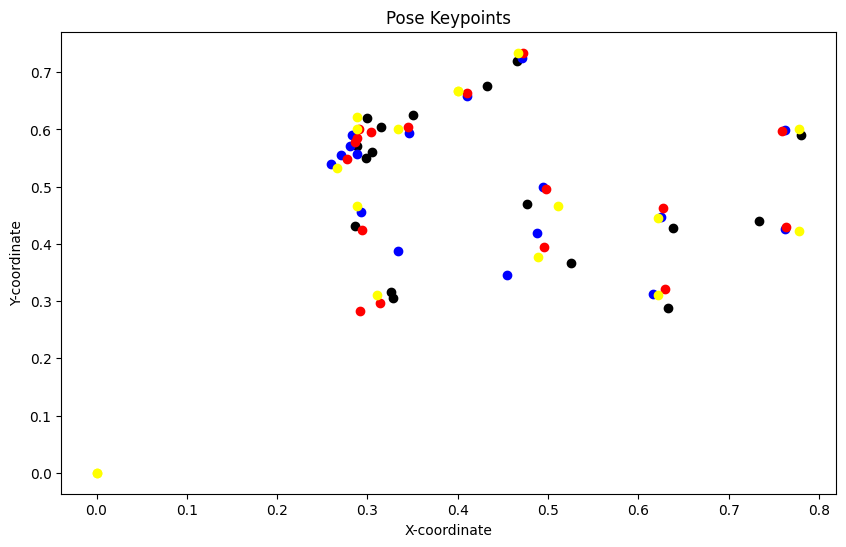

In [33]:
# # Plotting keypoints from MoveNet
plt.figure(figsize=(10, 6))
for keypoint in actual_keypoints:
    x, y = keypoint
    plt.scatter(x, y, color='black', label='Actual')
    
for keypoint in movenet_keypoints:
    x, y, _ = keypoint
    plt.scatter(x, y, color='blue', label='MoveNet')

# Plotting keypoints from MediaPipe Pose
for keypoint in mediapipe_keypoints:
    x, y, _ = keypoint
    plt.scatter(x, y, color='red', label='MediaPipe Pose')
    
for keypoint in openpose_keypoints:
    x, y = keypoint
    plt.scatter(x, y, color='yellow', label='Open Pose')

# Set plot title and labels
plt.title('Pose Keypoints')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
# Show plot
plt.show()

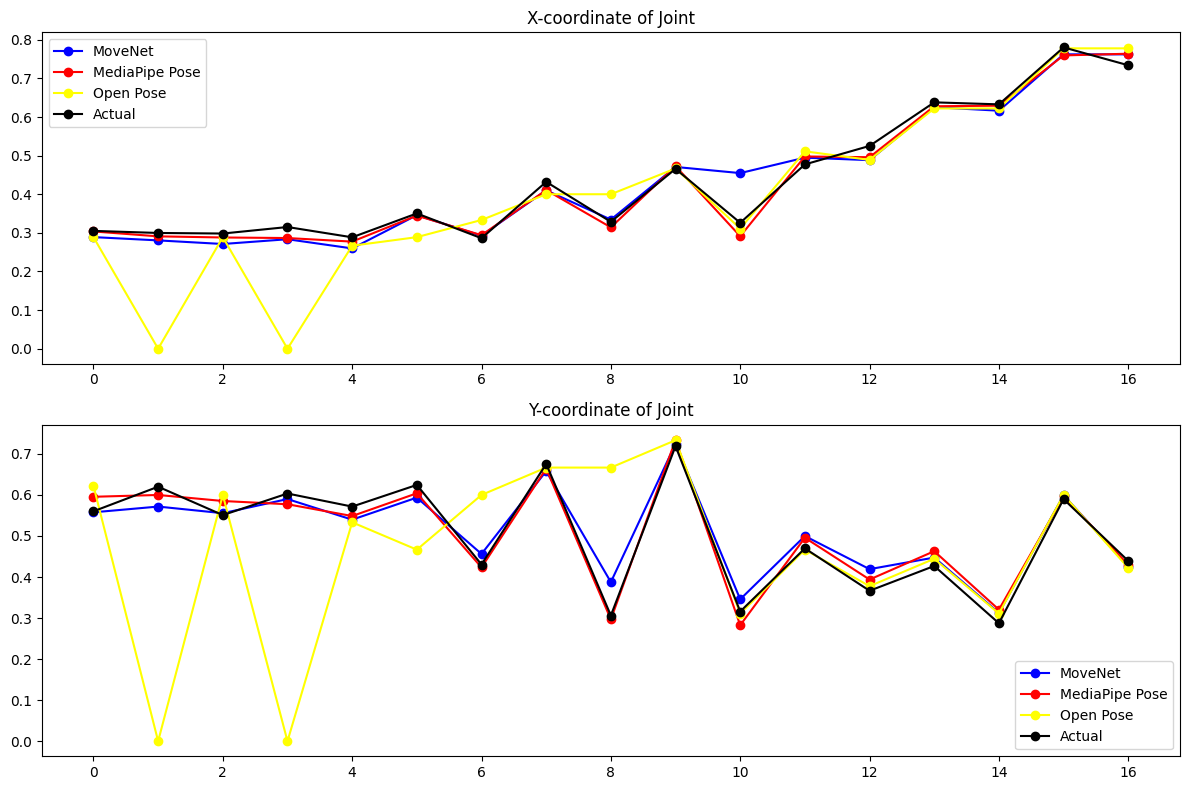

In [34]:
# Extract x and y coordinates from MoveNet and MediaPipe Pose
actual_x = [coord[0] for coord in actual_keypoints]
actual_y = [coord[1] for coord in actual_keypoints]

movenet_x = [coord[0] for coord in movenet_keypoints]
movenet_y = [coord[1] for coord in movenet_keypoints]

mediapipe_x = [coord[0] for coord in mediapipe_keypoints]
mediapipe_y = [coord[1] for coord in mediapipe_keypoints]

openpose_x = [coord[0] for coord in openpose_keypoints]
openpose_y = [coord[1] for coord in openpose_keypoints]

# Plot joint coordinates
plt.figure(figsize=(12, 8))

# Plot x coordinates
plt.subplot(211)
plt.plot(movenet_x, marker='o', linestyle='-', color='blue', label='MoveNet')
plt.plot(mediapipe_x, marker='o', linestyle='-', color='red', label='MediaPipe Pose')
plt.plot(openpose_x, marker='o', linestyle='-', color='yellow', label='Open Pose')
plt.plot(actual_x, marker='o', linestyle='-', color='black', label='Actual')
plt.title('X-coordinate of Joint')
plt.legend()

# Plot y coordinates
plt.subplot(212)
plt.plot(movenet_y, marker='o', linestyle='-', color='blue', label='MoveNet')
plt.plot(mediapipe_y, marker='o', linestyle='-', color='red', label='MediaPipe Pose')
plt.plot(openpose_y, marker='o', linestyle='-', color='yellow', label='Open Pose')
plt.plot(actual_y, marker='o', linestyle='-', color='black', label='Actual')
plt.title('Y-coordinate of Joint')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
import numpy as np

# Calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Calculate accuracy
def calculate_accuracy(predicted_keypoints, actual_keypoints):
    distances = [euclidean_distance(predicted_keypoint, actual_keypoint) for predicted_keypoint, actual_keypoint in zip(predicted_keypoints, actual_keypoints)]
    mean_distance = np.mean(distances)
    return mean_distance

# Calculate accuracy between predicted and actual keypoints
accuracy_movenet = calculate_accuracy(movenet_keypoints, actual_keypoints)
print("Movenet Accuracy:", accuracy_movenet)
# Calculate accuracy between predicted and actual keypoints
accuracy_mediapipe = calculate_accuracy(mediapipe_keypoints, actual_keypoints)
print("Mediapipe Accuracy:", accuracy_mediapipe)
# Calculate accuracy between predicted and actual keypoints
accuracy_openpose = calculate_accuracy(openpose_keypoints, actual_keypoints)
print("OpenPose Accuracy:", accuracy_openpose)


Movenet Accuracy: 0.040319352903252545
Mediapipe Accuracy: 0.028957330772013047
OpenPose Accuracy: 0.14604994388552495


In [36]:
import numpy as np

# Extract x, y coordinates from keypoints
def extract_xy(keypoints):
    return [[point[0], point[1]] for point in keypoints]

# Calculate Mean Squared Error (MSE)
def calculate_mse(predicted_keypoints, actual_keypoints):
    # Extract x, y coordinates
    predicted_keypoints = extract_xy(predicted_keypoints)
    # Convert lists to numpy arrays for easier computation
    predicted_keypoints = np.array(predicted_keypoints)
    actual_keypoints = np.array(actual_keypoints)
    
    # Calculate squared differences between corresponding keypoints
    squared_diff = np.square(predicted_keypoints - actual_keypoints)
    
    # Calculate mean squared error
    mse = np.mean(squared_diff)
    return mse

# Calculate MSE between predicted and actual keypoints
mse_movenet = calculate_mse(movenet_keypoints, actual_keypoints)
print("Movenet Mean Squared Error (MSE):", mse_movenet)
# Calculate MSE between predicted and actual keypoints
mse_mediapipe = calculate_mse(mediapipe_keypoints, actual_keypoints)
print("Mediapipe Mean Squared Error (MSE):", mse_mediapipe)
# Calculate MSE between predicted and actual keypoints
mse_openpose = calculate_mse(openpose_keypoints, actual_keypoints)
print("OpenPose Mean Squared Error (MSE):", mse_openpose)


Movenet Mean Squared Error (MSE): 0.00122451593908826
Mediapipe Mean Squared Error (MSE): 0.0004666466717533596
OpenPose Mean Squared Error (MSE): 0.033787562456421276


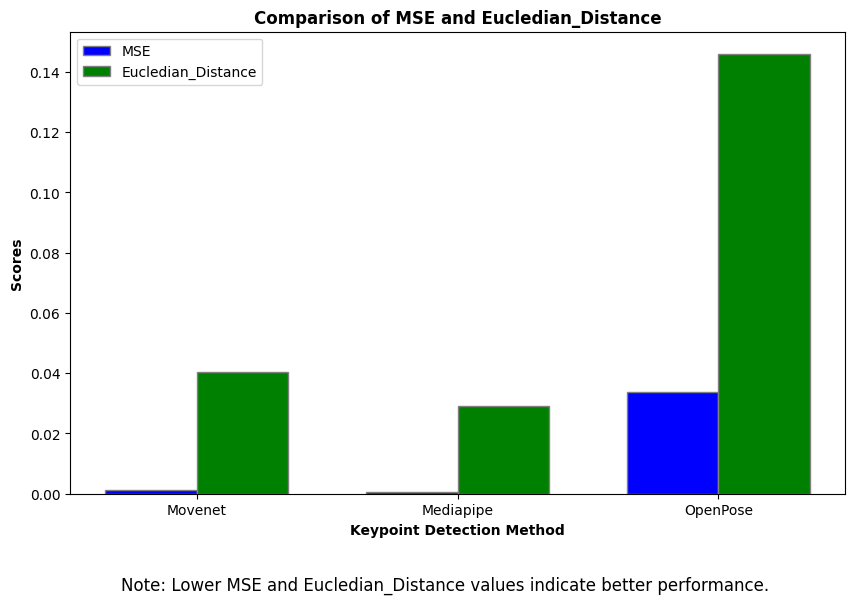

In [37]:
# Prepare data for plotting
methods = ['Movenet', 'Mediapipe', 'OpenPose']
mse_values = [mse_movenet, mse_mediapipe, mse_openpose]
accuracy_values = [accuracy_movenet, accuracy_mediapipe, accuracy_openpose]

# Create subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Set width of bar
bar_width = 0.35

# Set positions of bars on X axis
r1 = np.arange(len(methods))
r2 = [x + bar_width for x in r1]

# Make the plot
ax1.bar(r1, mse_values, color='b', width=bar_width, edgecolor='grey', label='MSE')
ax1.bar(r2, accuracy_values, color='g', width=bar_width, edgecolor='grey', label='Eucledian_Distance')

# Add labels
ax1.set_xlabel('Keypoint Detection Method', fontweight='bold')
ax1.set_ylabel('Scores', fontweight='bold')
ax1.set_title('Comparison of MSE and Eucledian_Distance', fontweight='bold')
ax1.set_xticks([r + bar_width / 2 for r in range(len(methods))])
ax1.set_xticklabels(methods)
ax1.legend()

# Adding a note
plt.figtext(0.5, -0.05, 'Note: Lower MSE and Eucledian_Distance values indicate better performance.', wrap=True, horizontalalignment='center', fontsize=12)

# Show the plot
plt.show()

In [38]:
# Tables for X,y coordinate visiblity if possible

In [39]:
# 3 Models MSE and Accuracy Lower is Higher